**ANLP GROUP 21: DATA SCRAPING CODES**

*Note: All codes need to be saved and run locally.*

This notebook summarises all the codes the group used for scraping datasets. Scraping was performed for the following companies:

1. Woolworths Group (code: WOW)

2. Commonwealth Bank of Australia (code: CBA)

3. CSL Limited (code: CSL)

4. BHP Company (code: BHP)

5. Telstra Group (code: TLS)

The different types of data collected for these companies include:

1. Job postings: from LinkedIn and Seek

2. Companies' social media postings: from LinkedIn

3. Company reviews: from Seek

4. Annual Reports: from individual company websites

5. Privacy Policies: from individual company websites

After scraping, the data will be saved to folders in CSV/txt format. For convenience in running the notebook, all codes that perform the actual scraping have been **commented (disabled)**. Only defined functions and classes are active. The scraping datasets in CSV format are saved to a separate `data` folder that should be put in the same path in order for this notebook to access.

This notebook also contains exploratory analysis for Annual Reports and Privacy Policies data.

# Download and import necessary packages

In [46]:
# !pip install PyPDF2
# !pip install pycryptodome
import pandas as pd
import numpy as np
import urllib.request
import io
import PyPDF2
import requests
import string
import nltk
import json
import math
import wordcloud
import matplotlib.pyplot as plt
import collections
import re

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from time import sleep

# Retrieve the list of ASX companies

The following retrieves ASX companies' information. The raw CSV dataset is downloaded from https://www2.asx.com.au/markets/trade-our-cash-market/directory.

In [2]:
### Import raw data from CSV file
asx_data = pd.read_csv('data/2020_asx_listed.csv', header=1)
asx_data.head()

,Code,Company,Sector,Market Cap,Weight(%),Unnamed: 5,Total Index Market Cap,Unnamed: 7
0,14D,1414 Degrees Ltd,Industrials,"19,020,000",0.001,NaN,"1,924,204,673,739",NaN
1,1ST,1ST Group Ltd,Health Care,"12,738,500",0.001,NaN,NaN,NaN
2,3PL,3P Learning Ltd,Consumer Discretionary,"104,613,000",0.005,NaN,Sector Breakdown,NaN
3,4DS,4DS Memory Ltd,Information Technology,"48,978,900",0.003,NaN,Consumer Discretionary,1.87
4,5GN,5G Networks Ltd,NaN,"66,627,100",0.003,NaN,Consumer Staples,2.44


In [3]:
asx_data.shape

(2210, 8)

In [4]:
asx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code                    2210 non-null   object 
 1   Company                 2210 non-null   object 
 2   Sector                  1857 non-null   object 
 3   Market Cap              2210 non-null   object 
 4   Weight(%)               2210 non-null   float64
 5   Unnamed: 5              0 non-null      float64
 6   Total Index Market Cap  13 non-null     object 
 7   Unnamed: 7              11 non-null     float64
dtypes: float64(3), object(5)
memory usage: 138.2+ KB


In [5]:
drop_cols = list(range(4, 8))
asx_data.drop(asx_data.columns[drop_cols], axis=1, inplace=True)

In [6]:
asx_data.head()

,Code,Company,Sector,Market Cap
0,14D,1414 Degrees Ltd,Industrials,"19,020,000"
1,1ST,1ST Group Ltd,Health Care,"12,738,500"
2,3PL,3P Learning Ltd,Consumer Discretionary,"104,613,000"
3,4DS,4DS Memory Ltd,Information Technology,"48,978,900"
4,5GN,5G Networks Ltd,NaN,"66,627,100"


In [7]:
def lower(string):
    """
    Lowers an input string.
    
    Args:
        string (str): the input string
        
    Returns:
        (str): string in lowercase
    """
    return string.lower()

In [8]:
# lowercase Company names
asx_data['Company'] = asx_data['Company'].apply(lower)
asx_data['Code'] = asx_data['Code'].apply(lower)

In [9]:
# Fill NaN's and lowercase Sector names
asx_data['Sector'].fillna('Other', inplace=True)
asx_data['Sector'] = asx_data['Sector'].apply(lower)

In [10]:
# Process market cap column
asx_data['Market Cap'] = asx_data['Market Cap'].str.replace(',', '', ).astype(int)

In [11]:
asx_data.head()

,Code,Company,Sector,Market Cap
0,14d,1414 degrees ltd,industrials,19020000
1,1st,1st group ltd,health care,12738500
2,3pl,3p learning ltd,consumer discretionary,104613000
3,4ds,4ds memory ltd,information technology,48978900
4,5gn,5g networks ltd,other,66627100


In [12]:
# Drop all ETFs
bool_etf = ~asx_data['Company'].str.contains('etf')
asx_data = asx_data[bool_etf].copy()

In [13]:
### Save to CSV file

# asx_data.to_csv('data/asx_listed_cleaned/asx_listed_cleaned.csv', index=False, encoding='utf-8')

# Scraping Annual Reports Data

In [14]:
### Read CSL Annual Reports

#Define a list of URLs for the PDF files to be read
urls = ["https://investors.csl.com/site/pdf/6a655c4d-f962-469f-adf9-e6ad1b8ecf02/CSL-Statutory-Accounts-for-the-Half-Year-Ended-31-Dec-2022.pdf", 
        "https://investors.csl.com/site/pdf/6626eeca-ac0a-4d76-9f8f-7329c36381c0/CSL-Statutory-Accounts-for-the-Full-Year-Ended-30-June-2022.pdf",
        "https://investors.csl.com/site/pdf/9abab631-2946-493e-a2da-0f7825c72bef/Statutory-Accounts-for-Half-Year-Ended-31-December-2021.pdf",
        "https://investors.csl.com/site/pdf/6e04479c-a394-42d2-bd7d-7c0da00691b5/CSL-Statutory-Accounts-for-the-Full-Year-Ended-30-June-2021.pdf",
        "https://investors.csl.com/site/pdf/58340bdf-d266-472b-81fa-447b02047378/Statutory-Accounts-for-the-Half-Year-Ended-31-Dec-2020.pdf",
        "https://investors.csl.com/site/pdf/560e940f-5cd9-4af6-9a92-d1147effcd34/Statutory-Accounts-for-the-Full-Year-Ended-30-June-2020.pdf",
        ]

# Initialize an empty string to store the combined text of all PDF files
combined_text = ""

# Iterate over each URL and read its corresponding PDF file
for url in urls:
    # Download the PDF file from the URL
    response = urllib.request.urlopen(url)
    pdf_bytes = io.BytesIO(response.read())

    # Read the PDF file using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_bytes)

    # Extract the text from the PDF file
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    # Add the text to the combined text string
    combined_text += text

# Store the combined text as a data object
CSL_ARs = combined_text

############ Read CBA Annual Reports

# Define a list of URLs for the PDF files to be read
urls = ["https://www.commbank.com.au/content/dam/commbank-assets/investors/docs/results/1h23/CBA-1H23-Profit-Announcement.pdf",
        "https://www.commbank.com.au/content/dam/commbank-assets/about-us/2022-08/2022-annual-report_print.pdf",
        "https://www.commbank.com.au/content/dam/commbank-assets/investors/docs/results/1h22/CBA-1H22-Profit-Announcement.pdf", 
        "https://www.commbank.com.au/content/dam/commbank-assets/about-us/2021-08/2021-annual-report_print.pdf",
        "https://www.commbank.com.au/content/dam/commbank-assets/investors/docs/results/1h21/cba-1h21-profit-announcement.pdf",
        "https://www.commbank.com.au/content/dam/commbank/about-us/shareholders/pdfs/results/fy20/cba-2020-annual-report-print.pdf",
        "https://www.commbank.com.au/content/dam/commbank/about-us/shareholders/pdfs/results/1h20/cba-2020-half-year-results-profit-announcement.pdf",
        ]

# Initialize an empty string to store the combined text of all PDF files
combined_text = ""

# Iterate over each URL and read its corresponding PDF file
for url in urls:
    # Download the PDF file from the URL
    response = urllib.request.urlopen(url)
    pdf_bytes = io.BytesIO(response.read())

    # Read the PDF file using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_bytes)

    # Extract the text from the PDF file
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    # Add the text to the combined text string
    combined_text += text

# Store the combined text as a data object
CBA_ARs = combined_text

############ Read BHP Annual Reports

# Define a list of URLs for the PDF files to be read
urls = ["https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02633600-3A613015?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02564957-3A601684?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02553481-3A599108?access_token=83ff96335c2d45a094df02a206a39ff4", 
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02486628-3A587269?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02423972-3A576312?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02420992-3A575751?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02407965-3A572976?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02341540-3A561255?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02283953-3A550808?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02267673-3A547170?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02267673-3A547170?access_token=83ff96335c2d45a094df02a206a39ff4",
        "https://cdn-api.markitdigital.com/apiman-gateway/ASX/asx-research/1.0/file/2924-02203163-3A535110?access_token=83ff96335c2d45a094df02a206a39ff4"
        ]

# Initialize an empty string to store the combined text of all PDF files
combined_text = ""

# Iterate over each URL and read its corresponding PDF file
for url in urls:
    # Download the PDF file from the URL
    response = urllib.request.urlopen(url)
    pdf_bytes = io.BytesIO(response.read())

    # Read the PDF file using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_bytes)

    # Extract the text from the PDF file
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    # Add the text to the combined text string
    combined_text += text

# Store the combined text as a data object
BHP_ARs = combined_text

############ Read WOW Annual Reports

# Define a list of URLs for the PDF files to be read
urls = ["https://www.woolworthsgroup.com.au/content/dam/wwg/investors/reports/2022/full-year/Appendix%204E%20and%202022%20Annual%20Report.pdf",
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/investor-news/2022/february/F22%20Appendix%204D%20and%20Half-Year%20Financial%20Report.pdf",
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/investor-news/2021/Woolworths%20Group%202021%20Annual%20Report.pdf", 
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/asx-announcements/h23/Woolworths%20Group%20F23%20Appendix%204D%20and%20Half-Year%20Financial%20Report.pdf",
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/investor-news/2021/Appendix%204D%20and%202021%20Half-Year%20Financial%20Report.pdf",
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/investor-news/2020/2020%20Annual%20Report_FIN.pdf",
        "https://www.woolworthsgroup.com.au/content/dam/wwg/investors/investor-news/2020/Appendix%204D%20and%202020%20Half-Year%20Financial%20Report.pdf",
        ]

# Initialize an empty string to store the combined text of all PDF files
combined_text = ""

# Iterate over each URL and read its corresponding PDF file
for url in urls:
    # Download the PDF file from the URL
    response = urllib.request.urlopen(url)
    pdf_bytes = io.BytesIO(response.read())

    # Read the PDF file using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_bytes)

    # Extract the text from the PDF file
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    # Add the text to the combined text string
    combined_text += text

# Store the combined text as a data object
WOW_ARs = combined_text

############ Read TLS Annual Reports

# Define a list of URLs for the PDF files to be read
urls = ["https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf-h/Financial%20results%20for%20the%20half%20year%20ended%2031%20Dec%202022.pdf",
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf-g/TLS-Financial-results-for-the-full-year-ended-30-June-2022.pdf",
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf-g/Telstra%201H%20FY22%20Results.pdf", 
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf-g/120821-Financial-results-for-the-full-year-ended-30-June-2021.pdf",
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf%20F/110221-Financial-results-for-the-half-year-ended-31-December-2020.pdf",
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf%20F/130820-Financial-results-for-the-full-year-ended-30-June-2020.pdf",
        "https://www.telstra.com.au/content/dam/tcom/about-us/investors/pdf%20F/130220-Financial-results-for-the-half-year-ended-31-December-2019.pdf",
        ]

# Initialize an empty string to store the combined text of all PDF files
combined_text = ""

# Iterate over each URL and read its corresponding PDF file
for url in urls:
    # Download the PDF file from the URL
    response = urllib.request.urlopen(url)
    pdf_bytes = io.BytesIO(response.read())

    # Read the PDF file using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_bytes)

    # Extract the text from the PDF file
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    # Add the text to the combined text string
    combined_text += text

# Store the combined text as a data object
TLS_ARs = combined_text

# Scraping Privacy Policy Data

In [15]:
########################################################################################### CSL Privacy Policy


# Define a list of URLs to scrape
urls = ["https://www.csl.com/privacy-policy", "https://www.csl.com/marketing-statement"]

# Loop through each URL and extract the text content
for url in urls:
    # Send a request to the website and get the HTML content
    response = requests.get(url)
    html_content = response.content

    # Use Beautiful Soup to extract the text content from the HTML tags
    soup = BeautifulSoup(html_content, 'html.parser')
    text_content = soup.get_text()


# Store the combined text as a data object
CSL_Privacy = text_content


########################################################################################### CBA Privacy Policy

urls = ["https://www.commbank.com.au/support/privacy.html", "https://www.commbank.com.au/support/privacy/privacy-collection-notice-nb-app.html"]

# Loop through each URL and extract the text content
for url in urls:
    # Send a request to the website and get the HTML content
    response = requests.get(url)
    html_content = response.content

    # Use Beautiful Soup to extract the text content from the HTML tags
    soup = BeautifulSoup(html_content, 'html.parser')
    text_content = soup.get_text()


# Store the combined text as a data object
CBA_Privacy = text_content


########################################################################################### BHP Privacy Policy

urls = ["https://www.bhp.com/privacy-policy"]

content_str = ""
content_str += response.content.decode("utf-8")

# Store the combined text as a data object
BHP_Privacy = content_str


########################################################################################### WOW Privacy Policy

urls = ["https://www.woolworthsgroup.com.au/au/en/privacy/policy-documents/privacy-policy.html"]

# Loop through each URL and extract the text content
for url in urls:
    # Send a request to the website and get the HTML content
    response = requests.get(url)
    html_content = response.content

    # Use Beautiful Soup to extract the text content from the HTML tags
    soup = BeautifulSoup(html_content, 'html.parser')
    text_content = soup.get_text()

# Store the combined text as a data object
WOW_Privacy = text_content

########################################################################################### TLS Privacy Policy

urls = ["https://www.telstra.com.au/privacy"]


# Loop through each URL and extract the text content
for url in urls:
    # Send a request to the website and get the HTML content
    response = requests.get(url)
    html_content = response.content

    # Use Beautiful Soup to extract the text content from the HTML tags
    soup = BeautifulSoup(html_content, 'html.parser')
    text_content = soup.get_text()

# Store the combined text as a data object
TLS_Privacy = content_str

# Store and Reload String Data Objects: ARs and PPs

In [ ]:
CSL_ARs_file_path = 'data/ar_pp_txt/CSL_ARs.txt'
CBA_ARs_file_path = 'data/ar_pp_txt/CBA_ARs.txt'
BHP_ARs_file_path = 'data/ar_pp_txt/BHP_ARs.txt'
WOW_ARs_file_path = 'data/ar_pp_txt/WOW_ARs.txt'
TLS_ARs_file_path = 'data/ar_pp_txt/TLS_ARs.txt'
CSL_Privacy_file_path = 'data/ar_pp_txt/CSL_Privacy.txt'
CBA_Privacy_file_path = 'data/ar_pp_txt/CBA_Privacy.txt'
BHP_Privacy_file_path = 'data/ar_pp_txt/BHP_Privacy.txt'
WOW_Privacy_file_path = 'data/ar_pp_txt/WOW_Privacy.txt'
TLS_Privacy_file_path = 'data/ar_pp_txt/TLS_Privacy.txt'

with open(CSL_ARs_file_path, 'w') as file:
    file.write(CSL_ARs)

with open(CBA_ARs_file_path, 'w') as file:
    file.write(CBA_ARs)

with open(BHP_ARs_file_path, 'w') as file:
    file.write(BHP_ARs)

with open(WOW_ARs_file_path, 'w') as file:
    file.write(WOW_ARs)

with open(TLS_ARs_file_path, 'w') as file:
    file.write(TLS_ARs)

with open(CSL_Privacy_file_path, 'w') as file:
    file.write(CSL_Privacy)

with open(CBA_Privacy_file_path, 'w') as file:
    file.write(CBA_Privacy)

with open(BHP_Privacy_file_path, 'w') as file:
    file.write(BHP_Privacy)

with open(WOW_Privacy_file_path, 'w') as file:
    file.write(WOW_Privacy)

with open(TLS_Privacy_file_path, 'w') as file:
    file.write(TLS_Privacy)

In [ ]:
CSL_ARs_file_path = 'data/ar_pp_txt/CSL_ARs.txt'
CBA_ARs_file_path = 'data/ar_pp_txt/CBA_ARs.txt'
BHP_ARs_file_path = 'data/ar_pp_txt/BHP_ARs.txt'
WOW_ARs_file_path = 'data/ar_pp_txt/WOW_ARs.txt'
TLS_ARs_file_path = 'data/ar_pp_txt/TLS_ARs.txt'
CSL_Privacy_file_path = 'data/ar_pp_txt/CSL_Privacy.txt'
CBA_Privacy_file_path = 'data/ar_pp_txt/CBA_Privacy.txt'
BHP_Privacy_file_path = 'data/ar_pp_txt/BHP_Privacy.txt'
WOW_Privacy_file_path = 'data/ar_pp_txt/WOW_Privacy.txt'
TLS_Privacy_file_path = 'data/ar_pp_txt/TLS_Privacy.txt'

# Read the files

with open(CSL_ARs_file_path, 'r') as f:
    CSL_ARs = f.read()

with open(CBA_ARs_file_path, 'r') as f:
    CBA_ARs = f.read()

with open(BHP_ARs_file_path, 'r') as f:
    BHP_ARs = f.read()

with open(WOW_ARs_file_path, 'r') as f:
    WOW_ARs = f.read()

with open(TLS_ARs_file_path, 'r') as f:
    TLS_ARs = f.read()

with open(CSL_Privacy_file_path, 'r') as f:
    CSL_Privacy = f.read()

with open(CBA_ARs_file_path, 'r') as f:
    CBA_Privacy = f.read()

with open(BHP_Privacy_file_path, 'r') as f:
    BHP_Privacy = f.read()

with open(WOW_ARs_file_path, 'r') as f:
    WOW_Privacy = f.read()

with open(TLS_Privacy_file_path, 'r') as f:
    TLS_Privacy = f.read()

# Scraping Job Posts Data

In [16]:
def check_null_rows(df):
    return df[df.isnull().any(axis=1)]

In [17]:
class BaseScraper(object):
    """
    The base scraper class, which stores the data and the URL for child scraper classes.
    
    """
    def __init__(self, raw_url):
        self.raw_url = raw_url
        self.data = []
        
    def save_data(self, path_name):
        """
        Save all data to a csv file, and returns the data as a Pandas DataFrame.
        
        ------------
        Input(s):
        path_name (str): the named path to store the csv file. E.g.: '/path1/path2/company.csv'
        
        Output(s):
        df (pd.DataFrame): the scraped data in Pandas DataFrame format.
        Also saves data to the path specified.
        
        """
        df = pd.DataFrame(self.data)
        df.to_csv(path_name, index=False, encoding='utf-8')
        
        return df


class LinkedInJobScraper(BaseScraper):
    """
    A custom LinkedIn Job Scraper object.
    
    ------------
    Initialisation parameters:
    total_jobs (int): the total number of jobs seen in the search.
    raw_url (str): the raw url with style and ?start={} removed, for scraping. For example: 
        https://au.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=&location=Australia&locationId=&geoId=101452733&f_TPR=&f_C=2848
    
    ------------
    Examples use of this object:
    
    - Without logging into LinkedIn, find jobs according to desired criteria on https://au.linkedin.com/jobs/search
    - On Google Chrome, open the developers tool, then navigate to the `Network` tab.
    - Scroll down on the jobs section, and as more jobs are loaded, look for an element appearing
      on the left-hand panel of the developers tool starting with `search?`. Click on that element.
    - Grab the Request URL on the right-hand panel of the developers tool. The URL looks like:
      https://au.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?start=25
    - Remove the `?start=25` at the end, and this will be the raw URL as input for the scraper.
    - The total jobs appeared at the beginning of the search page is also to be specified,
      to accurately calculate the number of loops to run during scrape().
    
    """
    def __init__(self, total_jobs, *args, **kwargs):
        super(LinkedInJobScraper, self).__init__(*args, **kwargs)
        self.total_jobs = total_jobs
     
    def scrape(self, debug=True, verbose=True):
        """
        Scrape the specified URL.
        
        ------------
        Input(s):
        debug (bool, default=True): for debugging only, and should be ignored.
        verbose (bool, default=True): whether to print progress for each individual job scraped.
        
        Output(s):
        None. Writes data into the `data` attribute of the class.
        
        """
        # Since each page contains 25 results, this is the total number of pages in the search
        num_pages_in_search = math.ceil(self.total_jobs / 25)
        
        # Calculate the list of starting positions for job search, to iterate
        iter_list = []
        count_page = 0
        while count_page < self.total_jobs:
            iter_list.append(count_page)
            count_page += 25
        
        # This logic ensures the calculation of the number of pages is correct
        if debug:
            assert num_pages_in_search == len(iter_list), \
            f'Mismatch between total pages in the search and total pages in iteration: \nnum_pages_in_search = {num_pages_in_search}, len(iter_list) = {len(iter_list)}'
        
        # Get the scraping URL from the raw URL
        url_scrape = "{}&start={}"
        
        # Initiate an empty job id list
        job_id_list = []
        
        # For each page of the search, scrape all job IDs and append to the list
        for i in iter_list:
            # Request the website to scrape
            res = requests.get(url_scrape.format(self.raw_url, i))

            # Parse the html of that site
            soup = BeautifulSoup(res.text, 'html.parser')

            # Find all jobs on the page, which are in 'li' tags
            jobs_on_this_page = soup.find_all('li')
            
            # For each jobs found, extract the job ID and append to job_id_list
            for j in range(len(jobs_on_this_page)):
                try:
                    job_id = jobs_on_this_page[j].find("div", {"class": "base-card"}).get('data-entity-urn').split(":")[3]
                    job_id_list.append(job_id)
                # If none found, continue search
                except AttributeError as none:
                    continue
        
        # Initiate a dictionary to store individual jobs scraped
        data_individual = {}
        
        # Declare a shortened URL for jobs, which only differs in the job ID
        url_job = 'https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}'

        # For each job ID, append it to the url_job string, scrape job information, and store
        for k in range(len(job_id_list)):
            if verbose:
                print(f'Scraping job {k+1} of {self.total_jobs}...')
            
            # request the URL
            resp = requests.get(url_job.format(job_id_list[k]))
            
            # Scrape job contents
            soup = BeautifulSoup(resp.text, 'html.parser')
            
            # Scrape company name
            try:
                data_individual["company"] = soup.find("div", {"class": "top-card-layout__card"}).find("a").find("img").get('alt')
            except:
                data_individual["company"] = None
            
            # Scrape job titles
            try:
                data_individual["job_title"] = soup.find("div", {"class":"top-card-layout__entity-info"}).find("a").text.strip()
            except:
                data_individual["job_title"] = None

            # Scrape seniority level
            try:
                data_individual["level"] = soup.find("ul", {"class": "description__job-criteria-list"}).find("li").text.replace("Seniority level","").strip()
            except:
                data_individual["level"] = None
            
            # Scrape job description
            try:
                data_individual["description"] = soup.find("div", {"class": "show-more-less-html__markup"}).text.strip()
            except:
                data_individual["description"] = None
            
            # Append the job to the stored data attribute
            self.data.append(data_individual)
            
            # Reset the individual data point to blank, ready for scraping the next job
            data_individual = {}
        
        if verbose:
            print('Done scraping all data.')
            

class SeekJobScraper(BaseScraper):
    
    def __init__(self, total_pages, *args, **kwargs):
        super(SeekJobScraper, self).__init__(*args, **kwargs)
        self.total_pages = total_pages
        
    def scrape(self, sleep_duration=3, verbose=True):
        """
        Scrape the specified URL.
        
        ------------
        Input(s):
        sleep_duration (int, default=3): sleep duration for each GET request.
        verbose (bool, default=True): whether to print progress for each individual job scraped.
        
        Output(s):
        None. Writes data into the `data` attribute of the class.
        
        """
        # Calculate the list of starting positions for job search, to iterate
        iter_list = [p+1 for p in range(self.total_pages)]
        
        # Get the scraping URL from the raw URL
        url_scrape = "{}&page={}"
        
        # Get the shortened job URL that only differs in the jobId at the end
        url_job = 'https://www.seek.com.au/job/{}'
    
        # For each page of the search, scrape all job details and append to data storage attribute
        for i in iter_list:
            # Request the website to scrape
            res = requests.get(url_scrape.format(self.raw_url, i))

            # Parse the html of that site, and parse the json object as dict
            soup = BeautifulSoup(res.text, 'html.parser')
            json_data = json.loads(soup.text)['data']
            num_jobs_on_this_page = len(json_data)

            # Initiate an individual data point to attach to
            data_individual = {}
            
            # For each job found, extract the job information
            for j in range(len(json_data)):
                try:
                    # Only get organic job listing
                    if json_data[j]['solMetadata']['jobAdType'] == 'ORGANIC':
                        if verbose:
                            print(f'Scraping job {j+1} of {num_jobs_on_this_page} on page {i}...')
                        
                        # Get company name
                        data_individual['company'] = json_data[j]['companyName']
                        
                        # Get the job title
                        data_individual['job_title'] = json_data[j]['title']
                        
                        # Get the job description by going into the job details page, using the shortened URL
                        job_id = json_data[j]['solMetadata']['jobId']
                        job_resp = requests.get(url_job.format(job_id))
                        
                        # Set sleep duration for each GET request, to allow for load time
                        if j != len(json_data) - 1:
                            sleep(sleep_duration)
                        
                        job_soup = BeautifulSoup(job_resp.text, 'html.parser')
                        try:
                            data_individual['description'] = job_soup.find('div', {'data-automation': 'jobAdDetails'}).find('div').text.strip()
                        except:
                            data_individual['description'] = None
                        
                        # Append the job details to the stored data attribute
                        self.data.append(data_individual)

                        # Reset the individual data point to blank, ready to scrape the next job
                        data_individual = {}
                
                # If any of above is not found, continue search
                except:
                    continue

        if verbose:
            print('Done scraping all data.')

## Scraping Job Posts on LinkedIn

In [18]:
### THIS BLOCK IS FOR SCRAPING LINKEDIN JOBS
### ----------------------------------------


# ### SCRAPING BHP JOBS

# bhp_scraper = LinkedInJobScraper(
#     147,
#     'https://au.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=&location=Australia&locationId=&geoId=101452733&f_TPR=&f_C=4509'
# )

# bhp_scraper.scrape()

# bhp_data = bhp_scraper.save_data('data/jobs_linkedin/bhp_jobs_linkedin.csv')


# ### SCRAPING TLS JOBS

# tls_scraper = LinkedInJobScraper(
#     total_jobs=80,
#     raw_url='https://au.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=&location=Australia&locationId=&geoId=101452733&f_TPR=&f_C=89885306%2C1635%2C122653%2C14383808%2C14455912%2C26547568%2C1636%2C3330130'
# )

# tls_scraper.scrape()

# tls_data = tls_scraper.save_data('data/jobs_linkedin/tls_jobs_linkedin.csv')


# ### SCRAPING WOW JOBS

# wow_scraper = LinkedInJobScraper(
#     61,
#     'https://au.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=&location=Australia&locationId=&geoId=101452733&f_TPR=&f_C=295257'
# )

# wow_scraper.scrape()

# wow_data = wow_scraper.save_data('data/jobs_linkedin/wow_jobs_linkedin.csv')


# ### ------------------------------------------------------------------------------------------
# ### CBA and CSL jobs' codes and URLs somehow disappeared at the time of compiling, so the URLs 
# ### for these companies do not represent the original URLs scraped. These are codes reproduced
# ### while compiling codes together, and are only for completion's sake.
# ### ------------------------------------------------------------------------------------------

# ### SCRAPING CBA JOBS

# cba_scraper = LinkedInJobsScraper(
#     342,
#     'https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=&location=Australia&locationId=&geoId=101452733&f_TPR=&f_C=2848'
# )

# cba_scraper.scrape()

# cba_data = cba_scraper.save_data('data/jobs_linkedin/cba_jobs_linkedin.csv')

# ### SCRAPING CSL JOBS

# csl_scraper = LinkedInJobsScraper(
#     28,
#     'https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=CSL&location=United%2BStates&locationId=&geoId=103644278&f_TPR=&f_C=2879949%2C263528%2C11473%2C7384'
# )

# csl_scraper.scrape()

# csl_data = csl_scraper.save_data('data/jobs_linkedin/csl_jobs_linkedin.csv')

## Processing LinkedIn job posts and save to a single file

In [19]:
wow = pd.read_csv('data/jobs_linkedin/wow_jobs_linkedin.csv')
tls = pd.read_csv('data/jobs_linkedin/tls_jobs_linkedin.csv')
cba = pd.read_csv('data/jobs_linkedin/cba_jobs_linkedin.csv')
bhp = pd.read_csv('data/jobs_linkedin/bhp_jobs_linkedin.csv')
csl = pd.read_csv('data/jobs_linkedin/csl_jobs_linkedin.csv')

full_data = [wow, tls, cba, bhp, csl]

In [20]:
full_df = pd.concat(full_data, ignore_index=True)
full_df.head()

,company,job_title,level,description
0,Woolworths Group,Data Engineering Lead,Mid-Senior level,About Woolworths GroupWoolworths Group is a fo...
1,Woolworths Group,Account Executive - AGW Wholesale,Mid-Senior level,About Woolworths GroupWoolworths Group is a fo...
2,Woolworths Group,HVAC & R Technician,Mid-Senior level,About Woolworths GroupWoolworths Group is a fo...
3,Woolworths Group,Analytics Engineering Manager,Mid-Senior level,"Lead teams in the design, development, impleme..."
4,Woolworths Group,IT Senior Business Analyst - Payments,Mid-Senior level,"About UsFounded within the Woolworths group, W..."


In [21]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   company      601 non-null    object
 1   job_title    601 non-null    object
 2   level        601 non-null    object
 3   description  601 non-null    object
dtypes: object(4)
memory usage: 19.2+ KB


In [22]:
full_df[full_df.isnull().any(axis=1)]

,company,job_title,level,description
214,NaN,NaN,NaN,NaN
215,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN
285,NaN,NaN,NaN,NaN
286,NaN,NaN,NaN,NaN
291,NaN,NaN,NaN,NaN
294,NaN,NaN,NaN,NaN
297,NaN,NaN,NaN,NaN
345,NaN,NaN,NaN,NaN


In [23]:
full_df.dropna(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 0 to 611
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   company      601 non-null    object
 1   job_title    601 non-null    object
 2   level        601 non-null    object
 3   description  601 non-null    object
dtypes: object(4)
memory usage: 23.5+ KB


In [24]:
### THIS BLOCK SAVES ALL LINKEDIN JOBS DATA TO A SINGLE CSV FILE

# full_df.to_csv('data/jobs_linkedin/all_jobs_linkedin.csv', index=False, encoding='utf-8')

## Scraping Job Posts on Seek

In [25]:
### THIS BLOCK PERFORMS SCRAPING
### ----------------------------

# ### CBA

# cba_seek_scraper = SeekJobScraper(
#     total_pages=10,
#     raw_url='https://www.seek.com.au/api/chalice-search/v4/search?siteKey=AU-Main&sourcesystem=houston&userqueryid=13bc85bd693e885e2fae2bdbb068900b-7439281&userid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&usersessionid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&eventCaptureSessionId=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&where=All+Australia&seekSelectAllPages=true&companyname=Commonwealth+Bank+of+Australia&include=seodata&locale=en-AU&solId=8e8f007e-f45c-4c00-913d-7c862f50c2cb'
# )

# cba_seek_scraper.scrape()

# cba_seek_jobs = cba_seek_scraper.save_data('data/jobs_seek/cba_jobs_seek.csv')


# ### CSL

# csl_seek_scraper = SeekJobScraper(
#     total_pages=2,
#     raw_url='https://www.seek.com.au/api/chalice-search/v4/search?siteKey=AU-Main&sourcesystem=houston&userqueryid=1b2af659e84347999573e079fb6fbfbc-4136558&userid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&usersessionid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&eventCaptureSessionId=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&where=All+Australia&seekSelectAllPages=true&companyname=CSL+Limited&include=seodata&locale=en-AU&solId=8e8f007e-f45c-4c00-913d-7c862f50c2cb'
# )

# csl_seek_scraper.scrape()

# csl_seek_jobs = csl_seek_scraper.save_data('data/jobs_seek/csl_jobs_seek.csv')


# ### BHP

# bhp_seek_scraper = SeekJobScraper(
#     total_pages=8,
#     raw_url='https://www.seek.com.au/api/chalice-search/v4/search?siteKey=AU-Main&sourcesystem=houston&userqueryid=f16954fddb5e149bc48c68471d640531-4750155&userid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&usersessionid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&eventCaptureSessionId=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&where=All+Australia&seekSelectAllPages=true&companyname=BHP&include=seodata&locale=en-AU&solId=8e8f007e-f45c-4c00-913d-7c862f50c2cb'
# )

# bhp_seek_scraper.scrape()

# bhp_seek_jobs = bhp_seek_scraper.save_data('data/jobs_seek/bhp_jobs_seek.csv')


# ### WOW

# wow_seek_scraper = SeekJobScraper(
#     total_pages=18,
#     raw_url='https://www.seek.com.au/api/chalice-search/v4/search?siteKey=AU-Main&sourcesystem=houston&userqueryid=374a27e499beb4e0f37790206a2bc966-5035864&userid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&usersessionid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&eventCaptureSessionId=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&where=All+Australia&seekSelectAllPages=true&companyname=Woolworths+Group&include=seodata&locale=en-AU&solId=8e8f007e-f45c-4c00-913d-7c862f50c2cb'
# )

# wow_seek_scraper.scrape(sleep_duration=2)

# wow_seek_jobs = wow_seek_scraper.save_data('data/jobs_seek/wow_jobs_seek.csv')


# ### TLS

# tls_seek_scraper = SeekJobScraper(
#     total_pages=7,
#     raw_url='https://www.seek.com.au/api/chalice-search/v4/search?siteKey=AU-Main&sourcesystem=houston&userqueryid=8a9f4c84f660d4709c8a71bcfa927813-5698512&userid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&usersessionid=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&eventCaptureSessionId=fb3867e8-2415-49bb-963a-a9cbdd9d7a23&where=All+Australia&seekSelectAllPages=true&companyname=Telstra&include=seodata&locale=en-AU&solId=8e8f007e-f45c-4c00-913d-7c862f50c2cb'
# )

# tls_seek_scraper.scrape(sleep_duration=2)

# tls_seek_jobs = tls_seek_scraper.save_data('data/jobs_seek/tls_jobs_seek.csv')

In [26]:
cba_seek_jobs = pd.read_csv('data/jobs_seek/cba_jobs_seek.csv')
csl_seek_jobs = pd.read_csv('data/jobs_seek/csl_jobs_seek.csv')
bhp_seek_jobs = pd.read_csv('data/jobs_seek/bhp_jobs_seek.csv')
wow_seek_jobs = pd.read_csv('data/jobs_seek/wow_jobs_seek.csv')
tls_seek_jobs = pd.read_csv('data/jobs_seek/tls_jobs_seek.csv')

full_seek_data = [
    cba_seek_jobs,
    csl_seek_jobs,
    bhp_seek_jobs,
    wow_seek_jobs,
    tls_seek_jobs
]

full_seek_data_df = pd.concat(full_seek_data, ignore_index=True)
full_seek_data_df.head()

,company,job_title,description
0,Commonwealth Bank of Australia,Business Banking Customer Service Representative,Work from home options availableStructured opp...
1,Commonwealth Bank of Australia,HR Advisor,See yourself in our team: People are a key pa...
2,Commonwealth Bank of Australia,Customer Service Representative - CommSec,You are available to work Monday to Friday bet...
3,Commonwealth Bank of Australia,Customer Service Representative - CommSec,You are available to work Monday to Friday bet...
4,Commonwealth Bank of Australia,Customer Service Specialist,About us: The Customer Service Remediation (...


In [27]:
check_null_rows(full_seek_data_df)

,company,job_title,description


In [28]:
full_seek_data_df.shape

(857, 3)

In [29]:
# full_seek_data_df.to_csv('data/jobs_seek/all_jobs_seek.csv', index=False, encoding='utf-8')

# Scraping LinkedIn Social Posts Data

In [30]:
class LinkedInPostScraper(BaseScraper):

    def __init__(self, n_posts, *args, **kwargs):
        super(LinkedInPostScraper, self).__init__(*args, **kwargs)
        self.n_posts = n_posts
        
    def scrape(self, sleep_duration=15, verbose=True):
        # Calculate the list of starting positions for posts, to iterate
        iter_list = []
        count_page = 0
        while count_page < self.n_posts:
            iter_list.append(count_page)
            count_page += 10
        
        # Get the scraping URL from the raw URL
        url_scrape = "{}&paginationStart={}"
        
        # For each page of the search, scrape all job IDs and append to the list
        for i in iter_list:
            # Request the website to scrape
            res = requests.get(url_scrape.format(self.raw_url, i))
            
            # Parse the html of that site
            soup = BeautifulSoup(res.text, 'html.parser')

            # Find all posts on the page, which are in "li" tags with class "mb-1"
            posts_on_this_page = soup.find_all("li", {"class": "mb-1"})
            
            len_page = len(posts_on_this_page)
            
            data_individual = {}
            
            # For each post found, extract the time posted and the text
            for j in range(len_page):
                if verbose:
                    print(f"Scraping post {j+1} of {len_page} on page {iter_list.index(i)+1}...")

                try:
                    data_individual["how_long_ago"] = posts_on_this_page[j].find("time", {"class": "flex-none"}).text.strip()
                except:
                    data_individual["how_long_ago"] = None
                
                try:
                    data_individual["text"] = posts_on_this_page[j].find("p", {"class": "attributed-text-segment-list__content"}).text.strip()
                except:
                    data_individual["text"] = None
                
                self.data.append(data_individual)
            
                # Reset the individual data point to blank, ready for scraping the next page
                data_individual = {}
            
            # Sleep if not the final iteration
            if i != iter_list[-1]:
                if verbose:
                    print(f"Sleeping for {sleep_duration} seconds...")
                sleep(sleep_duration)
        
        if verbose:
            print('Done scraping all data.')

In [31]:
### THIS BLOCK PERFORMS POSTS SCRAPING
### ----------------------------------


# ### CBA

# cba_posts = LinkedInPostScraper(
#     100,
#     'https://au.linkedin.com/organization-guest/api/feedUpdates/2848?paginationToken=0-1683168175429-16b40a8931ec77ea61c48afa9ed1d75c'
# )

# cba_posts.scrape()

# cba_posts_df = cba_posts.save_data('data/posts_linkedin/cba_posts_linkedin.csv')


# ### WOW

# wow_posts = LinkedInPostScraper(
#     70,
#     'https://au.linkedin.com/organization-guest/api/feedUpdates/295257?paginationToken=0-1683170025354-f5fbb4ba0f710d993a13ccb6a38856cc'
# )

# wow_posts.scrape()

# wow_posts_df = wow_posts.save_data('data/posts_linkedin/wow_posts_linkedin.csv')


# ### TLS

# tls_posts = LinkedInPostScraper(
#     70,
#     'https://au.linkedin.com/organization-guest/api/feedUpdates/1636?paginationToken=0-1683170747332-d2cb91dc377a60f24f98652aa1b48db2'
# )

# tls_posts.scrape()

# tls_posts_df = tls_posts.save_data('data/posts_linkedin/tls_posts_linkedin.csv')


# ### BHP

# bhp_posts = LinkedInPostScraper(
#     70,
#     'https://au.linkedin.com/organization-guest/api/feedUpdates/4509?paginationToken=0-1683171487220-230ee5aec2bb676e90406661fbf7f75c'
# )

# bhp_posts.scrape()

# bhp_posts_df = bhp_posts.save_data('data/posts_linkedin/bhp_posts_linkedin.csv')


# ### CSL

# csl_posts = LinkedInPostScraper(
#     70,
#     'https://au.linkedin.com/organization-guest/api/feedUpdates/7384?paginationToken=0-1683171857393-645f77d2a456e4ab39beb71977fe2245'
# )

# csl_posts.scrape()

# csl_posts_df = csl_posts.save_data('data/posts_linkedin/csl_posts_linkedin.csv')

In [32]:
### THIS BLOCK CONCATENATES ALL POSTS DATA
### --------------------------------------

# all_data = [cba_posts_df, wow_posts_df, tls_posts_df, bhp_posts_df, csl_posts_df]

# names = ['Commonwealth Bank', 'Woolworths Group', 'Telstra', 'BHP', 'CSL']

# for i in range(len(all_data)):
#     all_data[i].insert(0, 'company', names[i])
    
# all_data_df = pd.concat(all_data, ignore_index=True)

# check_null_rows(all_data_df)

In [33]:
### THIS BLOCK SAVES DATA INTO A SINGLE FILE
### ----------------------------------------

# all_data_df.to_csv('data/posts_linkedin/all_posts_linkedin.csv', index=False, encoding='utf-8')

# Defining the Data Dictionary

In [35]:
## Dictionary details
## -----------------------------------
collection = [
    'data mining',
    'mining data',
    'mine data',
    'data scraping',
    'scraping data',
    'scrape data',
    'scraping',
    'scrape',
    'data acquisition',
    'acquire data',
    'acquiring data',
    'data gathering',
    'gathering data',
    'gather data',
    'data extraction',
    'data extracting',
    'extract data',
    'extracting data',
    'data sources',
    'data retrieval',
    'data retrieving',
    'retrieving data',
    'retrieve data'
]

quality = [
    'data validation',
    'validate data',
    'validating data',
    'data validity',
    'valid data',
    'validity of data',
    'data cleaning',
    'cleaning data',
    'clean data',
    'data cleansing',
    'standardise data',
    'standardize data',
    'data standardisation',
    'data standardization',
    'pre-process data',
    'pre-process',
    'pre-processing data',
    'pre-processing',
    'data pre-processing',
    'preprocess data',
    'preprocessing data',
    'data preprocessing',
    'process data',
    'processing data',
    'data processing',
    'data accuracy',
    'accurate data',
    'data consistency',
    'consistent data',
    'consistency data',
    'relevant data',
    'data relevance',
    'data relevancy',
    'data integrity'
]

analysis = [
    'statistics',
    'statistical',
    'statistical analysis',
    'analyse data',
    'analysing data',
    'data analysis',
    'data analytics',
    'analytics',
    'machine learning',
    'artificial intelligence',
    'natural language processing',
    'deep learning',
    'ml',
    'ai',
    'nlp',
    'predictive analytics',
    'prediction',
    'predictions',
    'predicting',
    'predict',
    'predictive',
    'mathematics',
    'mathematical',
    'mathematical analysis',
    'data modelling',
    'data modeling',
    'modeling data',
    'modeling of data',
    'modelling data',
    'data model',
    'data models',
    'visualise data',
    'visualize data',
    'data visualisation',
    'data visualization',
    'visualising data',
    'visualizing data',
    'data auditing',
    'audit data',
    'auditing of data',
    'data exploration',
    'data exploring',
    'exploring data',
    'explore data',
    'dashboard',
    'dashboards'
]

culture = [
    'data driven',
    'data drive',
    'evidence',
    'evidence based',
    'analytics driven',
    'insights',
    'metrics',
    'key performance indicators',
    'kpis',
    'kpi',
    'data culture',
    'culture data'
]

governance = [
    'data privacy',
    'data usage',
    'usage data',
    'use data',
    'data security',
    'data compliance',
    'data regulations',
    'data policy',
    'data policies',
    'disseminating data',
    'dissemination of data',
    'data dissemination',
    'data disseminating'
]

monetisation = [
    'data service',
    'data services',
    'data product',
    'data products',
    'data licensing',
    'licensing data',
    'data brokerage',
    'data exchange',
    'data marketplace',
    'data as a service',
    'data-as-a-service'
]

## -----------------------------------

## Building the dictionary
data_phases = [collection, quality, analysis, culture, governance, monetisation]
DATA_DICTIONARY = {phase+1: keyword for phase, keyword in enumerate(data_phases)}

# Exploratory Analysis: Term Search, Scoring

## Annual Reports Term search and scoring

In [36]:
########################################################################################## Search in CSL
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in CSL_ARs:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("Matches for Annual Reports CSL:", matches)
print("\nData Driven Score for CSL from Annual Reports:", max(matches))

########################################################################################## Search in CBA
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in CBA_ARs:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Annual Reports CBA:", matches)
print("\nData Driven Score for CBA from Annual Reports:", max(matches))

########################################################################################## Search in BHP
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in BHP_ARs:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Annual Reports BHP:", matches)
print("\nData Driven Score for BHP from Annual Reports:", max(matches))

########################################################################################## Search in WOW
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in WOW_ARs:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Annual Reports WOW:", matches)
print("\nData Driven Score for WOW from Annual Reports:", max(matches))

########################################################################################## Search in TLS
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in TLS_ARs:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Annual Reports TLS:", matches)
print("\nData Driven Score for TLS from Annual Reports:", max(matches))

Matches for Annual Reports CSL: [2, 3, 4]

Data Driven Score for CSL from Annual Reports: 4


Matches for Annual Reports CBA: [1, 2, 3, 4, 5]

Data Driven Score for CBA from Annual Reports: 5


Matches for Annual Reports BHP: [1, 2, 3, 4, 5]

Data Driven Score for BHP from Annual Reports: 5


Matches for Annual Reports WOW: [1, 3, 4]

Data Driven Score for WOW from Annual Reports: 4


Matches for Annual Reports TLS: [3, 4, 5, 6]

Data Driven Score for TLS from Annual Reports: 6


## Privacy Policies Term search and scoring

In [37]:
########################################################################################## Search in CSL
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in CSL_Privacy:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("Matches for Privacy CSL:", matches)
print("\nData Driven Score for CSL from Privacy Policy:", max(matches))


########################################################################################## Search in CBA
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in CBA_Privacy:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Privacy CBA:", matches)
print("\nData Driven Score for CBA from Privacy Policy:", max(matches))


########################################################################################## Search in BHP
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in BHP_Privacy:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Privacy BHP:", matches)
print("\nData Driven Score for BHP from Privacy Policy:", max(matches))


########################################################################################## Search in WOW
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in WOW_Privacy:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Privacy WOW:", matches)
print("\nData Driven Score for WOW from Privacy Policy:", max(matches))


########################################################################################## Search in TLS
# Initialize an empty list to store the matches
matches = []

# Iterate over each key-value pair in the dictionary and search for each term in the data object
for key, synonyms in DATA_DICTIONARY.items():
    for term in synonyms:
        if term in TLS_Privacy:
            matches.append(key)

# Remove duplicates from the list of matches
matches = list(set(matches))

# Print the matches
print("\n\nMatches for Privacy TLS:", matches)
print("\nData Driven Score for TLS from Privacy Policy:", max(matches))

Matches for Privacy CSL: [3]

Data Driven Score for CSL from Privacy Policy: 3


Matches for Privacy CBA: [3, 4]

Data Driven Score for CBA from Privacy Policy: 4


Matches for Privacy BHP: [3, 4]

Data Driven Score for BHP from Privacy Policy: 4


Matches for Privacy WOW: [2, 3, 4]

Data Driven Score for WOW from Privacy Policy: 4


Matches for Privacy TLS: [3, 4]

Data Driven Score for TLS from Privacy Policy: 4


# Finding Insights: Annual Reports and Privacy Policies

## Data Cleaning, and Pre-Processing

In [47]:
def clean_text(text):
    # convert the text to lowercase
    text = text.lower()

    # remove the punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove whitespaces
    text = " ".join(text.split())

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    text_tokens = text.split()
    text_cleaned = [word for word in text_tokens if word not in stop_words]

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    text_lemmatized = [lemmatizer.lemmatize(word) for word in text_cleaned]

    # join the lemmatized words back together
    text_lemmatized = " ".join(text_lemmatized)
    
    return text_lemmatized

# clean and process each string data object using the clean_text function
cleaned_CSL_ARs = clean_text(CSL_ARs)
cleaned_CBA_ARs = clean_text(CBA_ARs)
cleaned_BHP_ARs = clean_text(BHP_ARs)
cleaned_WOW_ARs = clean_text(WOW_ARs)
cleaned_TLS_ARs = clean_text(TLS_ARs)
cleaned_CSL_Privacy = clean_text(CSL_Privacy)
cleaned_CBA_Privacy = clean_text(CBA_Privacy)
cleaned_BHP_Privacy = clean_text(BHP_Privacy)
cleaned_WOW_Privacy = clean_text(WOW_Privacy)
cleaned_TLS_Privacy = clean_text(TLS_Privacy)

## Insights: Annual Reports

TLS Annual Reports score the highest, 6, amongst the other companies we analysed. This is followed by CBA, and BHP who scored 5 each. Lastly, CSL, and WOW scored 4.

Lets find out some insights from these Annual Reports.

### Word Counts 

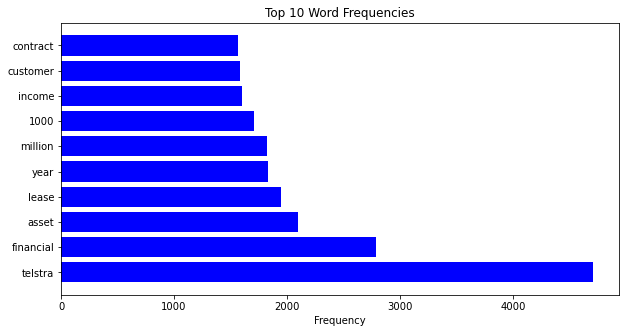

In [48]:
# lets do a word count on a bar chart for TLS
def count_words(text):
    words = re.findall('\w+', text.lower())
    word_counts = collections.Counter(words)
    return word_counts

# Call the count_words() function
word_counts = count_words(cleaned_TLS_ARs)

# Extract the top n word frequencies
n = 10
word_counts_top_n = word_counts.most_common(n)
words = [word[0] for word in word_counts_top_n]
frequencies = [word[1] for word in word_counts_top_n]

# Create a bar chart of the top n word frequencies
plt.figure(figsize=(10, 5))
plt.barh(words, frequencies, color='blue')
plt.xlabel('Frequency')
plt.title(f'Top {n} Word Frequencies')
plt.show()

From the above we can see that in Telstra Annual Reports it mentions its own name the most followed by the word "financial", and "Asset". Nothing from the our data-driven keyword list.

Lets check the second places

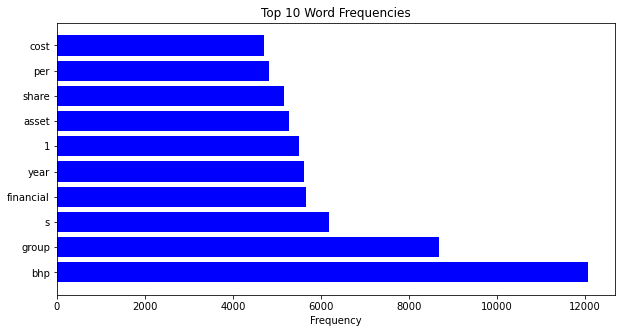

In [51]:
# lets do a word count on a bar chart for BHP
# Call the count_words() function
word_counts = count_words(cleaned_BHP_ARs)

# Extract the top n word frequencies
n = 10
word_counts_top_n = word_counts.most_common(n)
words = [word[0] for word in word_counts_top_n]
frequencies = [word[1] for word in word_counts_top_n]

# Create a bar chart of the top n word frequencies
plt.figure(figsize=(10, 5))
plt.barh(words, frequencies, color='blue')
plt.xlabel('Frequency')
plt.title(f'Top {n} Word Frequencies')
plt.show()

Like TLS, BHP has its own name mentions the most, followed by the word "group".

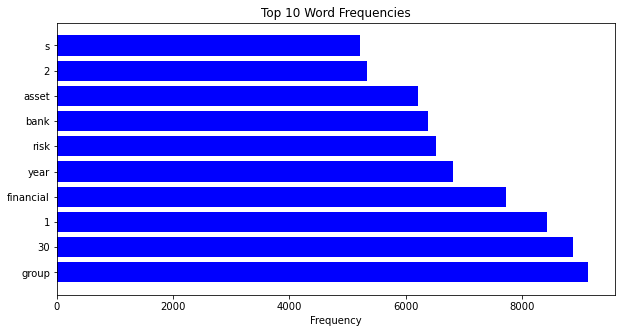

In [52]:
# lets do a word count on a bar chart for CBA
# Call the count_words() function
word_counts = count_words(cleaned_CBA_ARs)

# Extract the top n word frequencies
n = 10
word_counts_top_n = word_counts.most_common(n)
words = [word[0] for word in word_counts_top_n]
frequencies = [word[1] for word in word_counts_top_n]

# Create a bar chart of the top n word frequencies
plt.figure(figsize=(10, 5))
plt.barh(words, frequencies, color='blue')
plt.xlabel('Frequency')
plt.title(f'Top {n} Word Frequencies')
plt.show()

Unlike the the two we looked at earlier, CBA does not have its own name mentioned the most in their Annual Reports.

### Similarity

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Convert the strings to a list
corpus = [cleaned_BHP_ARs, cleaned_CBA_ARs]

# Create a count vectorizer to convert the corpus to a matrix of word counts
vectorizer = CountVectorizer().fit_transform(corpus)

# Use cosine similarity to compare the two strings
similarity_scores = cosine_similarity(vectorizer)

# Print the similarity score between the two strings
print("The similarity score between the two strings is:", similarity_scores[0,1])

The similarity score between the two strings is: 0.7061863318223052


A score of 0.7 between CBA, and BHP indicates a pretty high similarity, albeit they are not identical. Which can mean that the Annual Reports with the same data-driven score, will have a pretty similar text composition.

Lets test this with the two companies with the least score, WOW, and CSL.

In [54]:
# Convert the strings to a list
corpus = [cleaned_WOW_ARs, cleaned_CSL_ARs]

# Create a count vectorizer to convert the corpus to a matrix of word counts
vectorizer = CountVectorizer().fit_transform(corpus)

# Use cosine similarity to compare the two strings
similarity_scores = cosine_similarity(vectorizer)

# Print the similarity score between the two strings
print("The similarity score between the two strings is:", similarity_scores[0,1])

The similarity score between the two strings is: 0.7667984893337114


The similarity score is even higher than the simlarity between BHP, and CBA who scored higher in our data-driven score. This could support our initial assumption that companies with the same data-driven score would have a similar Annual Reports text.

However, this could also mean that Annual Report in general has the same structure, words, and overall text in general. To be more certain, we can test the similarity on all the ARs of all five companies.

In [55]:
# Convert the strings to a list
corpus = [cleaned_TLS_ARs, cleaned_BHP_ARs, cleaned_CBA_ARs, cleaned_WOW_ARs, cleaned_CSL_ARs]

# Create a count vectorizer to convert the corpus to a matrix of word counts
vectorizer = CountVectorizer().fit_transform(corpus)

# Use cosine similarity to compare the two strings
similarity_scores = cosine_similarity(vectorizer)

# Print the similarity score between the two strings
print("The similarity score between all the Annual Reports is:", similarity_scores[0,1])

The similarity score between all the Annual Reports is: 0.6458821020581738


A lower score than previously achieved. The similarity of the annual reports are moderate. This would support our initial assumption that companies with the same data-driven score in their ARs, would have a high similarity score in their ARs.

## Insights: Privacy Policy

Now we have analysed the Annual Reports, lets go into findings in the privacy policies.

### Word Counts

In the scoring of Privacy Policy, we do not have a company that achieve the highest score of 6, like in the Annual Report. Three companies achieved 5, and two achieve 4.

Lets look at the word frequency for the three companies

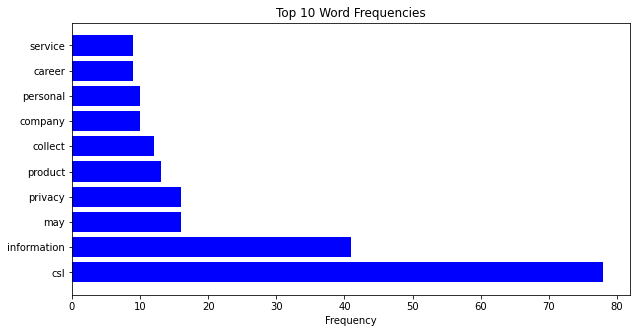

In [56]:
# Call the count_words() function
word_counts = count_words(cleaned_CSL_Privacy)

# Extract the top n word frequencies
n = 10
word_counts_top_n = word_counts.most_common(n)
words = [word[0] for word in word_counts_top_n]
frequencies = [word[1] for word in word_counts_top_n]

# Create a bar chart of the top n word frequencies
plt.figure(figsize=(10, 5))
plt.barh(words, frequencies, color='blue')
plt.xlabel('Frequency')
plt.title(f'Top {n} Word Frequencies')
plt.show()

CSL has the lowest data-driven score amongst the privacy score compared to the rest of the companies from Privacy Policy data source. However, just like the Annual Reports, it mentions its own name the most followed by the word "information", and "may".

Now, lets check the similarity between the four companies as they all scored 4.

### Similarity

In [57]:
# Convert the strings to a list
corpus = [cleaned_TLS_Privacy, cleaned_BHP_Privacy, cleaned_CBA_Privacy, cleaned_WOW_Privacy]

# Create a count vectorizer to convert the corpus to a matrix of word counts
vectorizer = CountVectorizer().fit_transform(corpus)

# Use cosine similarity to compare the two strings
similarity_scores = cosine_similarity(vectorizer)

# Print the similarity score between the two strings
print("The similarity score between the three Privacy Policies is:", similarity_scores[0,1])

The similarity score between the three Privacy Policies is: 0.999999999999984


Outstandingly identical. We can assume that companies with the same data-driven score will have an almost identical Privacy Policy.

Let's compare one of this company privacy policy with CSL privacy policy

In [50]:
# Convert the strings to a list
corpus = [cleaned_CSL_Privacy, cleaned_WOW_Privacy]

# Create a count vectorizer to convert the corpus to a matrix of word counts
vectorizer = CountVectorizer().fit_transform(corpus)

# Use cosine similarity to compare the two strings
similarity_scores = cosine_similarity(vectorizer)

# Print the similarity score between the two strings
print("The similarity score between the three Privacy Policies is:", similarity_scores[0,1])

The similarity score between the three Privacy Policies is: 0.4670606686401112


The similarity score is low. We can conclude then that in Privacy Policy, companies with different data-driven score will not have a similar Privacy Policy.

## WordCloud

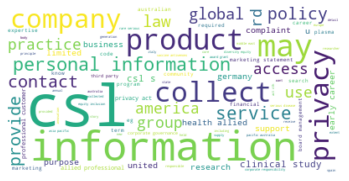

In [58]:
# lets do simple visualisation
# Create a WordCloud object
wordcloud = WordCloud(max_words=200, background_color="white")

# Generate a word cloud from the text
wordcloud.generate(cleaned_CSL_Privacy)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

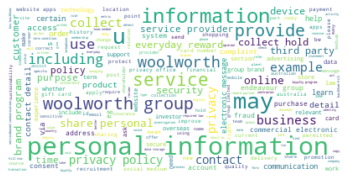

In [59]:
# lets do simple visualisation
# Create a WordCloud object
wordcloud = WordCloud(max_words=200, background_color="white")

# Generate a word cloud from the text
wordcloud.generate(cleaned_WOW_Privacy)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()